<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclassification/applications/classification/ner_tagging/NER%20tagging%20with%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers -q

     |████████████████████████████████| 778kB 8.1MB/s 
     |████████████████████████████████| 1.1MB 30.8MB/s 
     |████████████████████████████████| 3.0MB 53.4MB/s 
     |████████████████████████████████| 890kB 53.2MB/s 


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajag","key":"7c9b32c3baf1bd5e404db6e4e281fc5c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abhinavwalia95/entity-annotated-corpus

 34% 9.00M/26.4M [00:00<00:01, 17.3MB/s]
100% 26.4M/26.4M [00:00<00:00, 45.1MB/s]


In [5]:
!unzip entity-annotated-corpus.zip

Archive:  entity-annotated-corpus.zip
  inflating: ner.csv                 
  inflating: ner_dataset.csv         


In [6]:
import os
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from transformers import BertTokenizer, BertModel

from itertools import chain
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
datafile = 'ner_dataset.csv'

In [9]:
df = pd.read_csv(datafile, encoding="latin1", error_bad_lines=False)
df = df.fillna(method='ffill')

In [10]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [11]:
len(df)

1048575

In [12]:
tags = list(df.Tag.unique())
tags

['O',
 'B-geo',
 'B-gpe',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

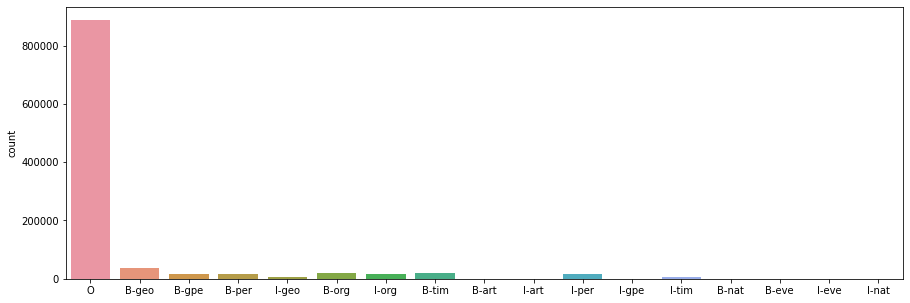

In [13]:
plt.figure(figsize=(15, 5))
sns.countplot(df.Tag.values)

In [14]:
num_tags = len(tags)
num_tags

17

In [15]:
agg_func = lambda s: [(w, t) for w, p, t in zip(s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist())]
group = df.groupby("Sentence #").apply(agg_func)
lines = [s for s in group]

In [16]:
lines[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [17]:
sentences = [[tokens[0] for tokens in line] for line in lines]
tags = [[tokens[1] for tokens in line] for line in lines]

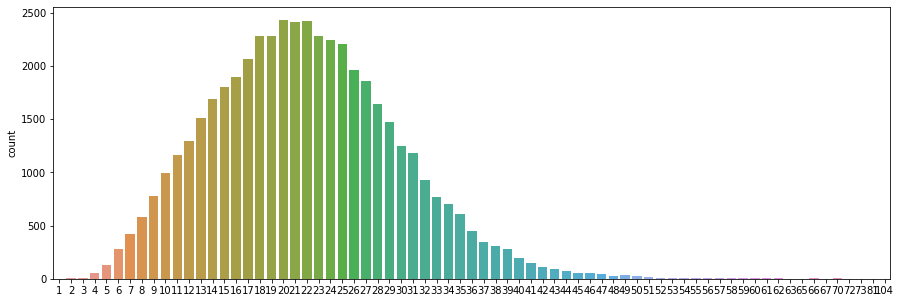

In [18]:
sen_lengths = [len(sent) for sent in sentences]
plt.figure(figsize=(15, 5))
sns.countplot(sen_lengths)

In [19]:
MAX_LEN = 60

In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [28]:
# get the special tokens, it is required to use these while encoding in Field
init_token = tokenizer.cls_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, pad_token_idx, unk_token_idx)

101 0 100


In [36]:
# limit the input tokens to max length - 1, [CLS] is the initial token
def convert_to_id(tokens, tokenizer, max_input_length=MAX_LEN):
    tokens = tokens[:max_input_length-1]
    tokens = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens)
    return tokens

def cut_tags(tag, max_input_length=MAX_LEN):
    tags = tag[:max_input_length-1]
    return tags

In [37]:
%%time
sentences_ids = [convert_to_id(line, tokenizer) for line in sentences]
tags = [cut_tags(tag) for tag in tags]

CPU times: user 975 ms, sys: 9.72 ms, total: 985 ms
Wall time: 986 ms


In [38]:
sentences_ids[0], tags[0]

([101,
  26159,
  1104,
  100,
  1138,
  9639,
  1194,
  1498,
  1106,
  5641,
  1103,
  1594,
  1107,
  5008,
  1105,
  4555,
  1103,
  10602,
  1104,
  1418,
  2830,
  1121,
  1115,
  1583,
  119],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-geo',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-gpe',
  'O',
  'O',
  'O',
  'O',
  'O'])

In [39]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [40]:
def build_vocab(tags, threshold=5):
    """Build a simple vocabulary wrapper."""
    counter = Counter(chain(*tags))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [41]:
tags_vocab = build_vocab(tags)
print("Total vocabulary size: {}".format(len(tags_vocab)))

Total vocabulary size: 18


In [42]:
tags_ids = [[tags_vocab('<pad>')] + [tags_vocab(t) for t in tag] for tag in tags]

In [45]:
train_sentences, valid_sentences, train_tags, valid_tags = train_test_split(sentences_ids, tags_ids, test_size=0.2, random_state=42)
valid_sentences, test_sentences, valid_tags, test_tags = train_test_split(valid_sentences, valid_tags, test_size=0.5, random_state=42)
len(train_sentences), len(valid_sentences), len(test_sentences)

(38367, 4796, 4796)

In [57]:
class NERDataset(data.Dataset):
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, item):
        sentence = self.sentences[item]
        tag = self.tags[item]

        return torch.LongTensor(sentence), torch.LongTensor(tag)

In [58]:
train_dataset = NERDataset(train_sentences, train_tags)
valid_dataset = NERDataset(valid_sentences, valid_tags)
test_dataset = NERDataset(test_sentences, test_tags)

In [60]:
train_dataset[0]

(tensor([  101,  1375,  3577,   100,  1433,  9667,  1145, 11770,   170,   100,
          2565,  1203, 18235, 19470,  7382,   117,  2637,  1106,  2561,   100,
          1207,  5448,   119]),
 tensor([0, 2, 6, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [61]:
BATCH_SIZE = 64

In [62]:
def collate_fn(data):
    data.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, tags = zip(*data)

    # Merge questions (from tuple of 1D tensor to 2D tensor).
    sent_lengths = [len(sent) for sent in sentences]
    inputs = torch.zeros(len(sentences), max(sent_lengths)).long()
    labels = torch.zeros(len(sentences), max(sent_lengths)).long()
    
    for i, (sent, lab) in enumerate(zip(sentences, tags)):
        end = sent_lengths[i]
        inputs[i, :end] = sent[:end]
        labels[i, :end] = lab[:end]

    return inputs, labels

In [63]:
train_data_loader = data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_data_loader = data.DataLoader(valid_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_data_loader = data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [64]:
sample = next(iter(train_data_loader))
sample[0].shape, sample[1].shape

(torch.Size([64, 38]), torch.Size([64, 38]))

In [67]:
class NERTagger(nn.Module):
    def __init__(self, output_dim, dropout):
        super().__init__()
        
        # bert model
        self.bert = BertModel.from_pretrained('bert-base-cased')
        
        # bert model hidden size
        d_model = self.bert.config.to_dict()['hidden_size']
        
        # prediction layer
        self.fc = nn.Linear(d_model, output_dim)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text):
        # text => [batch_size, seq_len]

        embedded = self.dropout(self.bert(text)[0])
        # only take the outputs, pooled output is not required
        # embedded => [batch_size, seq_len, d_model]

        predictions = self.fc(self.dropout(embedded))
        # predictions => [batch_size, seq_len, output_dim]

        return predictions

In [68]:
OUTPUT_DIM = len(tags_vocab)
DROPOUT = 0.4

model = NERTagger(OUTPUT_DIM, DROPOUT)

In [69]:
model = model.to(device)

In [70]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 108,324,114 trainable parameters


In [71]:
LR = 5e-5
TAG_PAD_IDX = tags_vocab('<pad>')

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX).to(device)

In [73]:
def train(model, iterator, criterion, optimizer):
    model.train()

    epoch_loss = 0

    for batch in iterator:
        text = batch[0].to(device)
        tags = batch[1].to(device)
        # text => [seq_len, batch_size]
        # tags => [seq_len, batch_size]

        optimizer.zero_grad()

        logits = model(text)
        # logits => [batch_size, seq_len, output_dim]

        logits = logits.view(-1, logits.shape[-1])
        # logits => [batch_size * seq_len, output_dim]

        tags = tags.view(-1)
        # tags => [batch_size * seq_len]

        loss = criterion(logits, tags)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [74]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [batch_size, seq_len]
            # tags => [batch_size, seq_len]

            optimizer.zero_grad()

            logits = model(text)
            # logits => [batch_size, seq_len, output_dim]

            logits = logits.view(-1, logits.shape[-1])
            # logits => [batch_size * seq_len, output_dim]

            tags = tags.view(-1)
            # tags => [batch_size * seq_len]

            loss = criterion(logits, tags)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [75]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [77]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_data_loader, criterion, optimizer)
    valid_loss = evaluate(model, valid_data_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 5m 40s
	Train Loss: 0.212 | Val. Loss: 0.121
Epoch: 02 | Epoch Time: 5m 42s
	Train Loss: 0.114 | Val. Loss: 0.114
Epoch: 03 | Epoch Time: 5m 43s
	Train Loss: 0.091 | Val. Loss: 0.114
Epoch: 04 | Epoch Time: 5m 43s
	Train Loss: 0.072 | Val. Loss: 0.114
Epoch: 05 | Epoch Time: 5m 42s
	Train Loss: 0.056 | Val. Loss: 0.123
Epoch: 06 | Epoch Time: 5m 43s
	Train Loss: 0.044 | Val. Loss: 0.136
Epoch: 07 | Epoch Time: 5m 42s
	Train Loss: 0.035 | Val. Loss: 0.140
Epoch: 08 | Epoch Time: 5m 42s
	Train Loss: 0.028 | Val. Loss: 0.158
Epoch: 09 | Epoch Time: 5m 41s
	Train Loss: 0.023 | Val. Loss: 0.176
Epoch: 10 | Epoch Time: 5m 42s
	Train Loss: 0.018 | Val. Loss: 0.173


In [78]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [79]:
def cal_metrics(iterator):
    model.eval()
    epoch_loss = 0
    fin_outputs = []
    fin_targets = []

    with torch.no_grad():
        for batch in iterator:
            text = batch[0].to(device)
            tags = batch[1].to(device)
            # text => [seq_len, batch_size]
            # tags => [seq_len, batch_size]

            logits = model(text)
            # logits => [seq_len, batch_size, output_dim]

            predictions = logits.argmax(-1)

            fin_outputs.extend(predictions.detach().cpu().numpy().tolist())
            fin_targets.extend(tags.detach().cpu().numpy().tolist())

    assert len(fin_outputs) == len(fin_targets)
    mlb = MultiLabelBinarizer()
    trans_trg = mlb.fit_transform(fin_targets)
    trans_pred = mlb.transform(fin_outputs)

    cf = metrics.classification_report(trans_trg, trans_pred)
    print(cf)


In [80]:
cal_metrics(test_data_loader)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4796
           1       1.00      1.00      1.00      4795
           2       0.92      0.94      0.93      2496
           3       0.93      0.93      0.93      1303
           4       0.96      0.96      0.96      1688
           5       0.86      0.75      0.80      1623
           6       0.87      0.82      0.85       595
           7       0.91      0.90      0.91      1361
           8       0.89      0.97      0.92      1071
           9       0.84      0.83      0.83       879
          10       0.84      0.86      0.85       395
          11       0.33      0.07      0.12        42
          12       0.00      0.00      0.00        25
          13       0.29      0.67      0.40        12
          14       0.82      0.60      0.69        15
          15       0.00      0.00      0.00         4
          16       0.68      0.48      0.57        31
          17       0.31    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
